In [1]:
import numpy as np
import cv2
import pandas as pd
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.ensemble import RandomForestClassifier
import rasterio as rio
from sklearn.model_selection import train_test_split
import pickle

In [4]:
img = cv2.imread('../../data/data/ortho_train.tif')

In [69]:
img.shape

(7068, 5160, 3)

In [5]:
imgB = img[:, :, 0]
imgG = img[:, :, 1]
imgR = img[:, :, 2]

In [6]:
imgB1 = imgB.reshape(-1)
imgG1 = imgG.reshape(-1)
imgR1 = imgR.reshape(-1)

In [7]:
df = pd.DataFrame()

In [8]:
df['original_imgB'] = imgB1
df['original_imgG'] = imgG1
df['original_imgR'] = imgR1

In [9]:
def Gabor_features(df, img, label):
    num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []  #Create empty list to hold all kernels that we will generate in a loop
    for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  #Sigma with values of 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5

                    gabor_label = f'Gabor_{label}' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1  #Increment for gabor column label
    return df

In [10]:
for ind, val in enumerate([imgB1, imgG1, imgR1]):
    labels = ['B', 'G' , 'R']
    df = Gabor_features(df, val, labels[ind])

Gabor_B1
Gabor_B1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor_B2
Gabor_B2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor_B3
Gabor_B3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor_B4
Gabor_B4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor_B5
Gabor_B5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor_B6
Gabor_B6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor_B7
Gabor_B7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor_B8
Gabor_B8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor_B9
Gabor_B9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor_B10
Gabor_B10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor_B11
Gabor_B11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor_B12
Gabor_B12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor_B13
Gabor_B13 : theta= 0.0 : sigma= 3 : lamda= 1

Gabor_R30 : theta= 0.7853981633974483 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor_R31
Gabor_R31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
Gabor_R32
Gabor_R32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5


In [11]:
def extract_features(df, img, label):
    
    #Canny Edge
    print(f"Calculating Canny Edge for {label}")
    edges = cv2.Canny(img, 100,200)   #Image, min and max values
    edges1 = edges.reshape(-1)
    df[f'Canny Edge_{label}'] = edges1 #Add column to original dataframe
    
    #ROBERTS EDGE
    print(f"Calculating Robert's Edge for {label}")
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df[f'Roberts_{label}'] = edge_roberts1

    #SOBEL
    print(f"Calculating Sobel Edge for {label}")
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df[f'Sobel_{label}'] = edge_sobel1

    #SCHARR
    print(f"Calculating Scharr Edge for {label}")
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df[f'Scharr_{label}'] = edge_scharr1

    #PREWITT
    print(f"Calculating Prewitt Edge for {label}")
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df[f'Prewitt_{label}'] = edge_prewitt1

    #GAUSSIAN with sigma=3
    print(f"Calculating Gaussian Filter (sigma 3) for {label}")
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df[f'Gaussian_s3_{label}'] = gaussian_img1

    #GAUSSIAN with sigma=7
    print(f"Calculating Gaussian Filter (sigma 7) for {label}")
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df[f'Gaussian_s7_{label}'] = gaussian_img3

    #MEDIAN with sigma=3
    print(f"Calculating Median Filter (sigma 3) for {label}")
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df[f'Median_s3_{label}'] = median_img1

    #VARIANCE with size=3
    print(f"Calculating Variance Filter (sigma 3) for {label}")
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df[f'Variance_s3_{label}'] = variance_img1  #Add column to original dataframe
    
    return df

In [12]:
for ind, val in enumerate([imgB, imgG, imgR]):
    labels = ['B', 'G' , 'R']
    df = extract_features(df, val, labels[ind])

Calculating Canny Edge for B
Calculating Robert's Edge for B
Calculating Sobel Edge for B
Calculating Scharr Edge for B
Calculating Prewitt Edge for B
Calculating Gaussian Filter (sigma 3) for B
Calculating Gaussian Filter (sigma 7) for B
Calculating Median Filter (sigma 3) for B
Calculating Variance Filter (sigma 3) for B
Calculating Canny Edge for G
Calculating Robert's Edge for G
Calculating Sobel Edge for G
Calculating Scharr Edge for G
Calculating Prewitt Edge for G
Calculating Gaussian Filter (sigma 3) for G
Calculating Gaussian Filter (sigma 7) for G
Calculating Median Filter (sigma 3) for G
Calculating Variance Filter (sigma 3) for G
Calculating Canny Edge for R
Calculating Robert's Edge for R
Calculating Sobel Edge for R
Calculating Scharr Edge for R
Calculating Prewitt Edge for R
Calculating Gaussian Filter (sigma 3) for R
Calculating Gaussian Filter (sigma 7) for R
Calculating Median Filter (sigma 3) for R
Calculating Variance Filter (sigma 3) for R


In [13]:
df.shape

(36470880, 126)

In [14]:
with rio.open("../../data/data/tree_mask_train.tif") as tm:
    labeled_img = tm.read(1)

In [15]:
labeled_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1

In [20]:
with open("../../data/dataframe.pkl", 'wb') as out:
    pickle.dump(df, out)

In [2]:
with open("../../data/dataframe.pkl", 'rb') as inbound:
    df = pickle.load(inbound)

In [10]:
np.random.seed(7)

remove_n = round(df.shape[0]*0.9)
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [13]:
del df

In [11]:
df_subset.shape

(3647088, 127)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_subset.drop(labels = ['Labels'], axis=1), df_subset[['Labels']], random_state = 7)



In [14]:
RFM = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 7)

In [15]:
RFM.fit(X_train, y_train)

<ipython-input-15-37c1713c4963>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFM.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [16]:
test_preds = RFM.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

In [18]:
accuracy_score(y_test, test_preds)

0.9548867480027902

In [24]:
df_subset[df_subset['Labels'] == 0].shape[0]/df_subset.shape[0] * 100

94.89540696577653

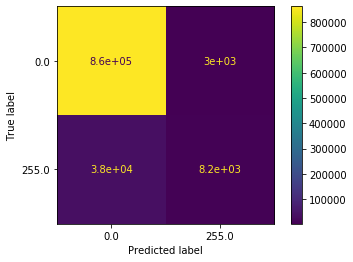

In [32]:
plot_confusion_matrix(RFM, X_test, y_test)

In [27]:
RFM.feature_importances_

array([1.32559751e-02, 1.32631385e-02, 1.38495854e-02, 0.00000000e+00,
       0.00000000e+00, 1.83940081e-03, 1.24343808e-02, 1.67945409e-02,
       1.44826220e-02, 1.54014890e-02, 1.28487977e-02, 0.00000000e+00,
       0.00000000e+00, 6.14785247e-03, 7.65559537e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.29526853e-03, 7.02317078e-04, 1.53724137e-02,
       2.24571584e-03, 1.71552844e-02, 1.11714190e-02, 0.00000000e+00,
       0.00000000e+00, 2.06613885e-03, 8.96055758e-05, 1.62587776e-02,
       1.36820281e-02, 1.56156670e-02, 1.52715121e-02, 0.00000000e+00,
       0.00000000e+00, 1.28900987e-03, 6.00105709e-03, 1.29599883e-02,
       1.32671612e-02, 1.24038605e-02, 9.56912059e-03, 0.00000000e+00,
       0.00000000e+00, 3.69439937e-03, 4.65664221e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.45777328e-04, 2.62884426e-04, 1.26411483e-02,
      

In [33]:
with open("RFM.pkl", 'wb') as out:
    pickle.dump(RFM, out)